In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# **Getting the normalized dataset:**

In [ ]:
# Get the mean, std of the pixel intensity values
def get_mean_and_std():
  # Get unnormalized data with pixel values [0,1]
  dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
  )

  # Split into 60_000/1_000 = 60 batches for faster processing
  loader = DataLoader(dataset, batch_size=1000, shuffle=False)
  mean, std, num_batches = 0.0, 0.0, 0

  for images, _ in loader:
    batch_samples = images.size(0)

    # Convert 28x28 arrray to 784x1
    images = images.view(batch_samples, -1)

    # Get mean and std for pixel values of the batch
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_batches += batch_samples

  mean /= num_batches
  std /= num_batches

  return mean.item(), std.item()

In [ ]:
# Get the train and test datasets loaders
def get_datasets(is_cnn = False):
  # Get the normalization mean and std
  mean, std = get_mean_and_std()

  # Convert and Normalize the data to a tensor (pixel values between 0 and 1) and flatten it to a 784 element list
  ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    transforms.Lambda(lambda x: x.view(-1))
  ])

  # Same as before but keep the 28x28 structure if its a CNN
  if is_cnn:
    ds_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((mean,), (std,)),
    ])

  # Get the transformed train and test datset
  complete_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ds_transform)
  complete_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ds_transform)

  train_loader = DataLoader(complete_train_dataset, batch_size=100, shuffle=True)
  test_loader = DataLoader(complete_test_dataset, batch_size=100, shuffle=False)

  return train_loader, test_loader

# **Model implementation**

In [ ]:
# activation functions and their derivatives
class ReLU:
  def activation(self,x):
    return np.maximum(0,x)

  def derivative(self,x):
    return np.where(x > 0, 1, 0)


class Tanh:
  def activation(self,x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

  def derivative(self, x):
    return 1 - np.square(self.activation(x))


class LeakyReLU:
  def __init__(self, y):
    self.gamma = y

  def activation(self, x):
    return np.maximum(0,x) + self.gamma*np.minimum(0,x)

  def derivative(self, x):
    return np.where(x > 0, 1, self.gamma)


class Softmax:
  def activation(self,x):
    sum = np.sum(np.exp(x), axis=0, keepdims=True) # should work for a matrix now
    return np.exp(x) / sum

  def derivative(self,x): #assumes that x is already a softmax vector
    n = x.shape[-1]
    jacobian = np.zeros((n,n))
    for i in range(0,n):
      for j in range(0,n):
        if i == j:
          jacobian[i,j] = x[i] * (1-x[i])
        else:
          jacobian[i,j] = -x[i] * x[j]
    return jacobian

class MultiClassLoss:
  def loss(self, pred, true): # assumes pred and true are vectors of the same size
    return -np.sum(true * np.log(pred))

  def derivative(self, pred, true): #returns the partial derivatives w.r.t. all the class probabilies
    return -true / pred

In [ ]:
class MLPBackpropagation:

    """
    Parameters:
    hidden_sizes = an int list that describes the number of units in each hidden layer
    inner_activation = an object that will be the activation function for all hidden layers
    final_activation = an object that will be the activation function for the output
    loss = an object that represents the loss function
    """
    def __init__(self, hidden_sizes, inner_activation, final_activation, loss, bias = True):
        self.hidden_sizes = hidden_sizes
        self.w_matrices = [None]
        self.biases = [None]

        for k in range(len(hidden_sizes)-1): #initialize V later when we recieved x
          w = np.random.randn(hidden_sizes[k+1], hidden_sizes[k]) * .01   #intialize with random gaussian noise
          self.w_matrices.append(w)

          if (bias):
            b = np.ones((1,hidden_sizes[k+1])) # keep separate for easier gradient calulation
            self.biases.append(b)

        # intialize the inner activation and the last activation (both are objects)
        self.inner_fn = inner_activation
        self.outer_fn = final_activation

        #need to intialize what is the loss function
        self.loss_fn = loss


    """
    given the features of 1 instance, compute the prediction
    """
    def forward(self, x):
      self.hidden_units = []
      self.activated_units = []

      units = x.reshape(-1, 1)

      #go through the hidden layers
      for i in range(len(self.w_matrices) - 1):
        # linear transformation on input
        units = np.dot(self.w_matrices[i], units).T + self.biases[i]
        units = units.reshape(-1, 1)
        self.hidden_units.append(units.copy())

        # activate
        units = self.inner_fn.activation(units)
        self.activated_units.append(units.copy())

      #produce the prediction
      y = np.dot(self.w_matrices[-1], units) + self.biases[-1].reshape(-1,1)
      self.hidden_units.append(y.copy())

      y = self.outer_fn.activation(y)
      self.activated_units.append(y.copy())

      return y


    """
    calculate the gradient of the weights using the given instance
    """
    def backward(self, x, pred_y, true_y): # assumes we are given just 1 instance
      # calculate the loss w.r.t. the output
      dy_hat = self.loss_fn.derivative(pred_y,true_y)

      # calculate the loss w.r.t. the outer activation
      if (isinstance(self.outer_fn, Softmax)):
        # simplify the formula so we dont need to calculate the jacobian
        da_list = [(pred_y.reshape(-1, 1) - true_y.reshape(-1, 1)).T]
      else:
        da_list = [np.dot(dy_hat,self.outer_fn.derivative(self.hidden_units[-1])).T]

      # check if the model has no hidden layers
      if (len(self.w_matrices) == 1):
        dw_list = [np.dot(x.reshape(-1,1), da_list[0]).T]
        db_list = [da_list[0]]
        return dw_list, db_list

      # calculate for the outer layer -> y = fn(a) = f(Wc + b) = f(W * g(d) + b) = ....
      dw_list = [np.dot(self.activated_units[-2], da_list[0]).T]
      db_list = [da_list[0]]

      # follow a similar formula for the hidden layers
      tot = len(self.activated_units)
      for i in range(1, tot - 1):
        da = np.dot(da_list[-1], self.w_matrices[tot-i])
        da = self.inner_fn.derivative(self.hidden_units[tot-i-1]).T * da
        da_list.append(da)
        dw_list.append(np.dot(self.activated_units[tot-i-2], da).T)
        db_list.append(da)

      #repeat one more time for the input layer
      da = np.dot(da_list[-1], self.w_matrices[1])
      da = self.inner_fn.derivative(self.hidden_units[0]).T * da
      dw_list.append(np.dot(x.reshape(-1,1),da).T)
      db_list.append(da)

      return dw_list, db_list


    """
    fits the model using X and Y and evaluate the perfomance per epoch if given a test set
    """
    def fit(self, X, Y, epoch, learning_rate = 0.05, testX = None, testY = None):
      features = X.shape[-1]
      classes = Y.shape[-1]

      # initalize the input weight matrix and bias
      if (self.hidden_sizes != []):
        self.w_matrices[0] = np.random.randn(self.hidden_sizes[0], features) * .01
        self.biases[0] = np.ones((1,self.hidden_sizes[0]))

        # intialize the output weight matrix
        self.w_matrices.append(np.random.randn(classes, self.hidden_sizes[-1]) * .01)
        self.biases.append(np.ones((1,classes)))

      else: # no hidden layers
        self.w_matrices[0] = np.random.randn(classes, features) * .01
        self.biases[0] = np.ones((1,classes))

      # training setup

      # determine how many weights to update
      matrices = len(self.w_matrices)

      # if given a test set, evaluate the performance of the model
      evaluate = isinstance(testX, np.ndarray) and isinstance(testY, np.ndarray)

      # initialize train_acc and test_acc (perfomance with no training)
      if (evaluate):
        train_result = self.predict(X)
        test_result = self.predict(testX)
        self.train_acc = [self.evaluate_acc(train_result, Y)]
        self.test_acc = [self.evaluate_acc(test_result, testY)]

      # determine how many instances we have
      if (X.ndim == 1):
        instances = 1
      else:
        instances = X.shape[0]

      # SDG
      for i in range(epoch):
        for j in range(instances):

          # get gradient for each instance
          if (X.ndim == 1):
            pred = self.forward(X).flatten()
            grad_w, grad_b = self.backward(X, pred.reshape(-1,1), Y)
          else:
            pred = self.forward(X[j,:]).flatten()
            grad_w, grad_b = self.backward(X[j,:], pred.reshape(-1,1), Y[j,:])

          #update the weight backwards due to how grad_w and grad_b are stored
          for k in range(matrices):
            self.w_matrices[k] -= learning_rate * grad_w[matrices-1-k]
            self.biases[k] -= learning_rate * grad_b[matrices-1-k]

        # calculate performance per epoch
        if (evaluate):
          train_result = self.predict(X)
          test_result = self.predict(testX)
          self.train_acc.append(self.evaluate_acc(train_result, Y))
          self.test_acc.append(self.evaluate_acc(test_result, testY))



    """
    given a set of predictions and true labels, determine the accuracy of the model
    """
    def evaluate_acc(self, pred, true):
      # assumes model is doing mulit-classification where classes = 1,2,...,k
      # and that the true labels are one hot encoded
      correct = 0
      total = len(pred)
      for i in range(total):
        # determine which class is chosen
        c = np.argmax(pred[i])
        t = np.argmax(true[i])

        # check true label
        if c == t:
          correct += 1
      return correct / total


    """
    given a set of instances, compute the prediction
    """
    def predict(self, X):
      if (X.ndim == 1):
        return self.forward(X)
      else:
        # need to do more than 1 forward pass
        predictions = np.zeros((X.shape[0],10))

        for i in range(X.shape[0]):
          p = self.forward(X[i,:]).flatten()
          predictions[i,:] = self.forward(X[i,:]).flatten()

        return predictions


In [ ]:
# example usage:
a = ReLU()
b = Softmax()
loss = MultiClassLoss()
model = MLPBackpropagation([3,4], a, b, loss)

# dataset
c = np.array([[1,2], [3,2]])
d = np.array([[0,1,0,0,0,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0]])
u = np.array([[1,2], [3,2]])
v = np.array([[0,1,0,0,0,0,0,0,0,0], [0,0,0,0,1,0,0,0,0,0]])

model.fit(c,d,2,0.05,u,v)

print(model.w_matrices)
print(model.biases)

# gives the performance of the model after each epoch (starts at epoch = 0)
print(model.train_acc)
print(model.test_acc)





[array([[-0.00887012, -0.0006326 ],
       [-0.00266154, -0.02137475],
       [-0.00374831, -0.01258845]]), array([[-0.00148664, -0.00201177,  0.01248697],
       [ 0.00076109, -0.00546214,  0.00258449],
       [ 0.01771792,  0.00789625,  0.00988787],
       [-0.02205463,  0.00132387, -0.00295447]]), array([[-0.01793693, -0.04234122, -0.01373082, -0.01655797],
       [ 0.0565294 ,  0.08362823,  0.09009713,  0.06711527],
       [-0.0240732 , -0.01543212, -0.0223693 , -0.01481796],
       [-0.02161826, -0.01977443, -0.00334565,  0.00182939],
       [ 0.08474325,  0.07628665,  0.08728935,  0.07434883],
       [-0.02897312, -0.02374642, -0.0130974 , -0.00786239],
       [-0.00971053, -0.01511436, -0.01293287, -0.02424816],
       [-0.00645742, -0.03341212, -0.01950461, -0.0350789 ],
       [-0.0144764 , -0.03204569,  0.00543394, -0.01485557],
       [-0.02896831, -0.02589097, -0.01973847, -0.02130086]])]
[array([[0.99998553, 0.9999694 , 1.00003303]]), array([[1.00199548, 1.0045735 , 1.0033

# **Additional preprocessing to the dataset:** Encoding the categorical labels

In [ ]:
def oneHotEncoding(Y):
  # given an array of labels, one hot encode them
  n = Y.shape[0]
  encoded = np.zeros((n,10))

  # one hot encoding (if class = k, set the k-th value = 1)
  for i in range(n):
    c = Y[i]
    encoded[i,c] = 1

  return encoded


# get our normalized dataset
training_data, testing_data = get_datasets()

# split data to inputs and labels
trainX, trainY = next(iter(training_data))
testX, testY = next(iter(testing_data))

# convert to numpy array
trainX = trainX.numpy()
trainY = trainY.numpy()
testX = testX.numpy()
testY = testY.numpy()

# one hot encode the labels
trainY = oneHotEncoding(trainY)
testY = oneHotEncoding(testY)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.34MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 136kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


# **Using the Test Set Accuracy to Select the Learning Rate Hyperparameter:**

In [ ]:
def getBestPerformance(alpha):
  # trains a model with 1 hidden layer (256 units) and gets the best achieved acurracy
  g = Softmax()
  loss = MultiClassLoss()
  relu = ReLU()

  model = MLPBackpropagation([256], relu, g, loss)
  model.fit(trainX, trainY, 50, alpha,testX, testY)

  return max(model.test_acc)

# test the performance of 4 different learning rates
rates = [0.5, 0.05, 0.005, 0.0005]
for r in rates:
  print("Performance with rate %f: %f" % (r, getBestPerformance(r)))

/tmp/ipython-input-1916942245.py:31: RuntimeWarning: overflow encountered in exp
  sum = np.sum(np.exp(x), axis=0, keepdims=True) # should work for a matrix now
/tmp/ipython-input-1916942245.py:32: RuntimeWarning: overflow encountered in exp
  return np.exp(x) / sum
/tmp/ipython-input-1916942245.py:32: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / sum
/tmp/ipython-input-1916942245.py:50: RuntimeWarning: divide by zero encountered in divide
  return -true / pred
/tmp/ipython-input-1916942245.py:50: RuntimeWarning: invalid value encountered in divide
  return -true / pred


Performance with rate 0.500000: 0.090000
Performance with rate 0.050000: 0.440000
Performance with rate 0.005000: 0.700000
Performance with rate 0.000500: 0.680000


# **Task 3: Experiment #1**

Training set performance: [0.1, 0.82, 0.94, 0.95, 0.91, 0.97, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.1, 0.54, 0.58, 0.61, 0.63, 0.66, 0.64, 0.65, 0.66, 0.66, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67] 




<Figure size 1200x480 with 0 Axes>

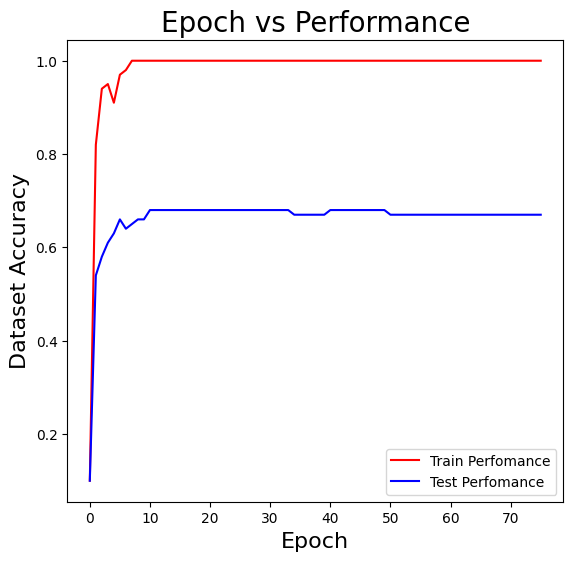

In [ ]:
g = Softmax()
loss = MultiClassLoss()

# model 1: no hidden layers + softmax at the end
model_no_hidden = MLPBackpropagation([], lambda x: x, g, loss)
model_no_hidden.fit(trainX, trainY, 75, 0.005,testX, testY)

# evalulate performance
m0_train = model_no_hidden.train_acc
m0_test = model_no_hidden.test_acc

print("Training set performance:", m0_train)
print("Test set performance:", m0_test,'\n\n')

# plot the performance vs epoch
epochs = np.arange(0, 76)

plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, m0_train, label = "Train Perfomance", color = 'r')
plt.plot(epochs, m0_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()

Training set performance: [0.12, 0.43, 0.6, 0.7, 0.82, 0.85, 0.85, 0.9, 0.93, 0.95, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.08, 0.38, 0.49, 0.54, 0.62, 0.6, 0.62, 0.66, 0.67, 0.67, 0.68, 0.68, 0.69, 0.68, 0.69, 0.69, 0.69, 0.7, 0.69, 0.69, 0.69, 0.69, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67] 




<Figure size 1200x480 with 0 Axes>

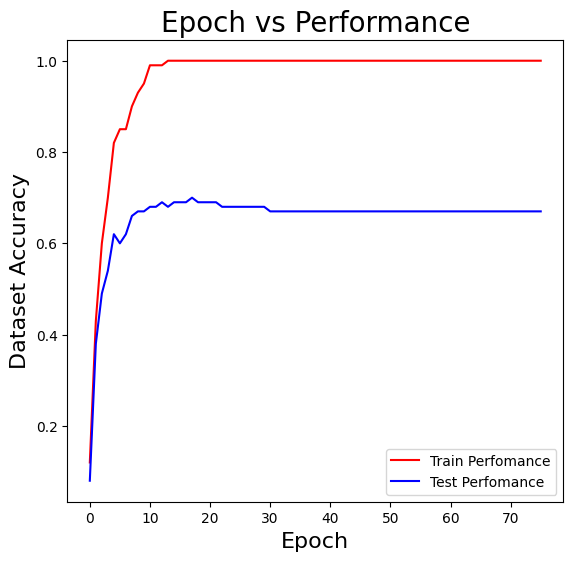

In [ ]:
# model 2: 1 hidden layer (256 units) with ReLU activations + softmax at the end
relu = ReLU()
model_1_hidden = MLPBackpropagation([256], relu, g, loss)
model_1_hidden.fit(trainX, trainY, 75, 0.005,testX, testY)

# evalulate performance
m1_train = model_1_hidden.train_acc
m1_test = model_1_hidden.test_acc

print("Training set performance:", m1_train)
print("Test set performance:", m1_test,'\n\n')

# plot the performance vs epoch
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, m1_train, label = "Train Perfomance", color = 'r')
plt.plot(epochs, m1_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()

Training set performance: [0.06, 0.12, 0.15, 0.34, 0.42, 0.43, 0.49, 0.56, 0.58, 0.63, 0.63, 0.64, 0.65, 0.7, 0.72, 0.72, 0.74, 0.74, 0.8, 0.8, 0.79, 0.83, 0.85, 0.88, 0.89, 0.9, 0.9, 0.92, 0.91, 0.93, 0.94, 0.95, 0.95, 0.95, 0.96, 0.97, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.09, 0.08, 0.15, 0.3, 0.37, 0.34, 0.42, 0.39, 0.45, 0.47, 0.49, 0.5, 0.5, 0.49, 0.49, 0.51, 0.5, 0.52, 0.53, 0.53, 0.56, 0.56, 0.56, 0.55, 0.58, 0.6, 0.61, 0.61, 0.63, 0.63, 0.63, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.62, 0.64, 0.65, 0.65, 0.65, 0.65, 0.66, 0.66, 0.67, 0.67, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65] 




<Figure size 1200x480 with 0 Axes>

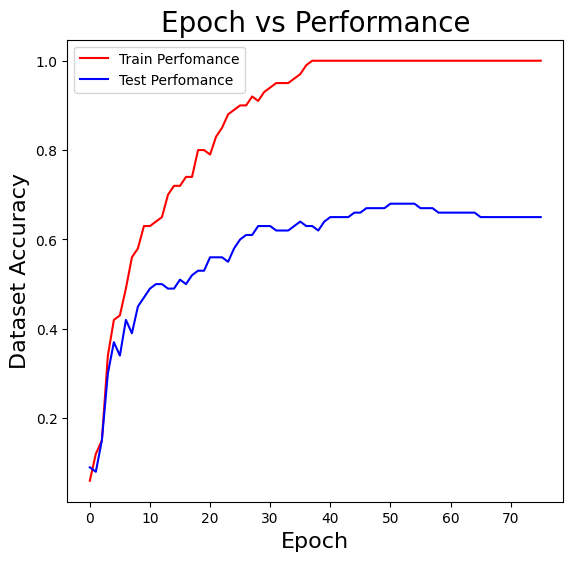

In [ ]:
# model 3: 2 hidden layers (both 256 units) with ReLU activations + softmax at the end
model_2_hidden = MLPBackpropagation([256,256], relu, g, loss)
model_2_hidden.fit(trainX, trainY, 75, 0.005,testX, testY)

# evalulate performance
m2_train = model_2_hidden.train_acc
m2_test = model_2_hidden.test_acc

print("Training set performance:", m2_train)
print("Test set performance:", m2_test,'\n\n')

# plot the performance vs epoch
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, m2_train, label = "Train Perfomance", color = 'r')
plt.plot(epochs, m2_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()


* # Comparing the test performance between the 3 models:

<Figure size 1200x480 with 0 Axes>

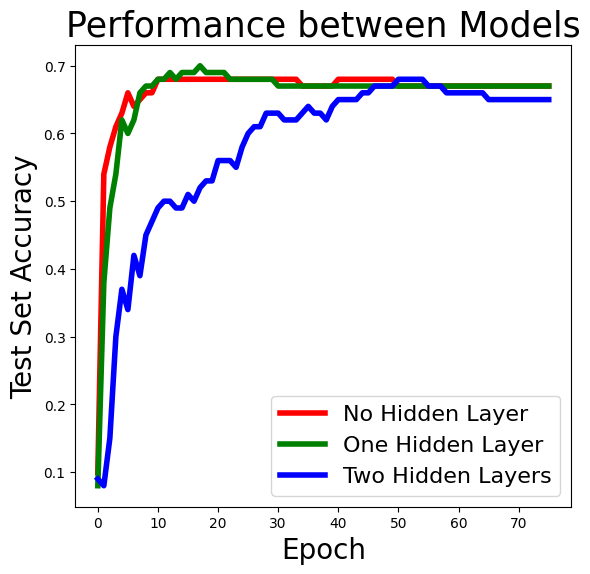

In [ ]:
# comparing test performance between the 3 models
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, m0_test, label = "No Hidden Layer", color = 'r', linewidth = 4)
plt.plot(epochs, m1_test, label = "One Hidden Layer", color = 'g', linewidth = 4)
plt.plot(epochs, m2_test, label = "Two Hidden Layers", color = 'b', linewidth = 4)

plt.title("Performance between Models", fontsize = 25)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Test Set Accuracy", fontsize = 20)
plt.legend(fontsize = 16)

plt.show()

# **Task 3: Experiment #2**

Training set performance: [0.08, 0.12, 0.12, 0.12, 0.13, 0.1, 0.1, 0.1, 0.13, 0.3, 0.42, 0.41, 0.52, 0.53, 0.56, 0.55, 0.6, 0.63, 0.68, 0.71, 0.73, 0.74, 0.77, 0.78, 0.8, 0.8, 0.83, 0.83, 0.83, 0.85, 0.86, 0.85, 0.87, 0.87, 0.89, 0.92, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.95, 0.97, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.06, 0.08, 0.08, 0.08, 0.13, 0.09, 0.09, 0.09, 0.14, 0.23, 0.38, 0.31, 0.46, 0.54, 0.56, 0.56, 0.58, 0.58, 0.57, 0.59, 0.59, 0.58, 0.59, 0.59, 0.6, 0.61, 0.62, 0.61, 0.63, 0.64, 0.64, 0.64, 0.64, 0.65, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.68, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.67, 0.67, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68] 




<Figure size 1200x480 with 0 Axes>

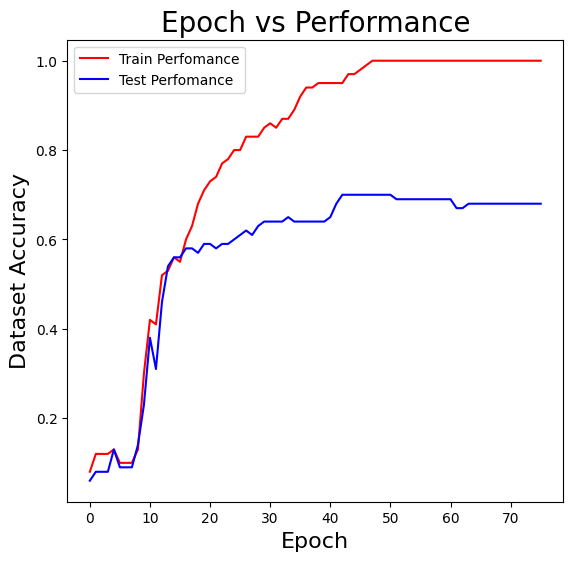

In [ ]:
# model 3 except it uses tanh in the hidden layers
tanh = Tanh()
tanh_model = MLPBackpropagation([256,256], tanh, g, loss)
tanh_model.fit(trainX, trainY, 75, 0.005,testX, testY)

# evalulate performance
tanh_train = tanh_model.train_acc
tanh_test = tanh_model.test_acc

print("Training set performance:", tanh_train)
print("Test set performance:", tanh_test,'\n\n')

# plot the performance vs epoch
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, tanh_train, label = "Train Perfomance", color = 'r')
plt.plot(epochs, tanh_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()


* # Use the test set accuracy to select the gamma hyperparameter for leaky ReLU:



In [ ]:
def getBestGammaPerformance(y):
  # trains a model with 1 hidden layer (256 units) and gets the best achieved acurracy
  g = Softmax()
  loss = MultiClassLoss()
  f = LeakyReLU(y)

  model = MLPBackpropagation([256], f, g, loss)
  model.fit(trainX, trainY, 50, 0.005,testX, testY)

  return max(model.test_acc)

# test the performance of 4 different gammas
gammas = [0.1, 0.01, 0.001, 0.0001]
for y in gammas:
  print("Performance with rate %f: %f" % (y, getBestPerformance(y)))

Performance with rate 0.100000: 0.190000
Performance with rate 0.010000: 0.700000
Performance with rate 0.001000: 0.670000
Performance with rate 0.000100: 0.520000


Training set performance: [0.09, 0.12, 0.16, 0.29, 0.39, 0.47, 0.47, 0.54, 0.59, 0.62, 0.65, 0.64, 0.67, 0.71, 0.73, 0.79, 0.82, 0.85, 0.86, 0.86, 0.86, 0.88, 0.9, 0.91, 0.92, 0.91, 0.92, 0.93, 0.93, 0.93, 0.94, 0.95, 0.95, 0.95, 0.95, 0.96, 0.97, 0.97, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.1, 0.08, 0.15, 0.25, 0.34, 0.43, 0.5, 0.43, 0.47, 0.48, 0.51, 0.5, 0.49, 0.52, 0.57, 0.6, 0.65, 0.67, 0.66, 0.64, 0.66, 0.67, 0.66, 0.66, 0.65, 0.65, 0.65, 0.65, 0.64, 0.66, 0.65, 0.65, 0.65, 0.66, 0.67, 0.66, 0.65, 0.65, 0.64, 0.64, 0.65, 0.65, 0.65, 0.66, 0.66, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65] 




<Figure size 1200x480 with 0 Axes>

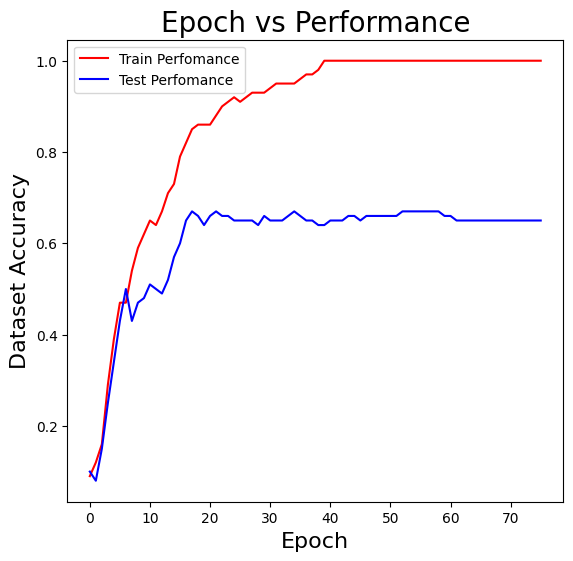

In [ ]:
# model 3 except it uses leaky ReLU in the hidden layers
leaky_relu = LeakyReLU(0.01)
leaky_model = MLPBackpropagation([256,256], leaky_relu, g, loss)
leaky_model.fit(trainX, trainY, 75, 0.005,testX, testY)

# evalulate performance
leaky_train = leaky_model.train_acc
leaky_test = leaky_model.test_acc

print("Training set performance:", leaky_train)
print("Test set performance:", leaky_test,'\n\n')

# plot the performance vs epoch
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, leaky_train, label = "Train Perfomance", color = 'r')
plt.plot(epochs, leaky_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()

* # Compare the Relu, tanh, and leaky ReLU performance:

<Figure size 1200x480 with 0 Axes>

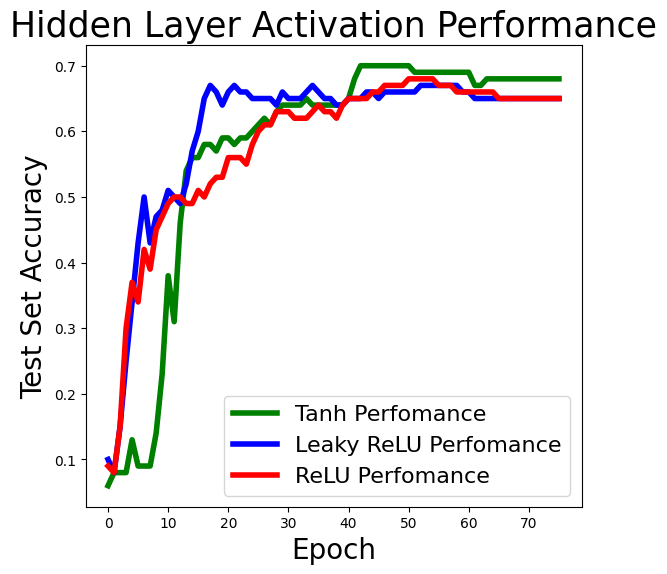

In [ ]:
# compare the performance between using ReLU, tanh, and leaky ReLu in the hidden layer activation
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(epochs, tanh_test, label = "Tanh Perfomance", color = 'g', linewidth = 4)
plt.plot(epochs, leaky_test, label = "Leaky ReLU Perfomance", color = 'b', linewidth = 4)
plt.plot(epochs, m2_test, label = "ReLU Perfomance", color = 'r', linewidth = 4)

plt.title("Hidden Layer Activation Performance", fontsize = 25)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Test Set Accuracy", fontsize = 20)
plt.legend(fontsize = 16)

plt.show()

# **Task 3: Experiment #4**

In [ ]:
# create new dataset transformation function
ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
  ])

# get the unnormalized train and test datasets with pixel values [0,1]
unloaded_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ds_transform)
unloaded_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ds_transform)

# load the datasets
unnorm_train = DataLoader(unloaded_train, batch_size=100, shuffle=True)
unnorm_test = DataLoader(unloaded_train, batch_size=100, shuffle=False)

# split data to inputs and labels
unnorm_trainX, unnorm_trainY = next(iter(unnorm_train))
unnorm_testX, unnorm_testY = next(iter(unnorm_test))

# convert to numpy array
unnorm_trainX = unnorm_trainX.numpy()
unnorm_trainY = unnorm_trainY.numpy()
unnorm_testX = unnorm_testX.numpy()
unnorm_testY = unnorm_testY.numpy()

# one hot encode the labels
unnorm_trainY = oneHotEncoding(unnorm_trainY)
unnorm_testY = oneHotEncoding(unnorm_testY)


Training set performance: [0.04, 0.09, 0.09, 0.12, 0.12, 0.28, 0.34, 0.38, 0.35, 0.36, 0.37, 0.38, 0.42, 0.43, 0.44, 0.44, 0.46, 0.46, 0.49, 0.51, 0.54, 0.56, 0.57, 0.58, 0.58, 0.58, 0.6, 0.6, 0.6, 0.6, 0.62, 0.62, 0.61, 0.62, 0.62, 0.62, 0.62, 0.66, 0.67, 0.68, 0.69, 0.71, 0.75, 0.76, 0.79, 0.81, 0.82, 0.83, 0.86, 0.86, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.89, 0.91, 0.91, 0.92, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.94, 0.96, 0.96, 0.96, 0.96, 0.97, 0.97, 0.97, 0.98, 0.97, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.15, 0.04, 0.04, 0.11, 0.11, 0.19, 0.25, 0.26, 0.23, 0.22, 0.23, 0.26, 0.26, 0.27, 0.27, 0.27, 0.27, 0.28, 0.28, 0.3, 0.3, 0.31, 0.32, 0.33

<Figure size 1200x480 with 0 Axes>

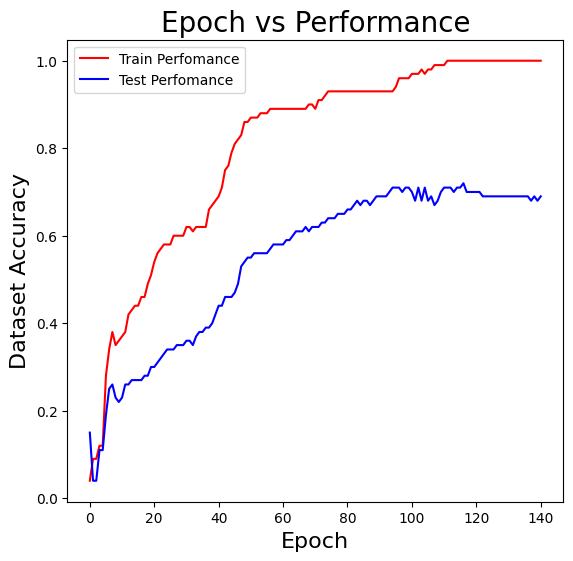

In [ ]:
# train model 3 except it uses the unnormalized dataset
unnorm_model = MLPBackpropagation([256,256], relu, g, loss)
unnorm_model.fit(unnorm_trainX, unnorm_trainY, 140, 0.005, unnorm_testX, unnorm_testY)

# evalulate performance
unnorm_train_acc = unnorm_model.train_acc
unnorm_test_acc = unnorm_model.test_acc

print("Training set performance:", unnorm_train_acc)
print("Test set performance:", unnorm_test_acc,'\n\n')

# plot the performance vs epoch
unnorm_epoch = np.arange(0,141)

plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(unnorm_epoch, unnorm_train_acc, label = "Train Perfomance", color = 'r')
plt.plot(unnorm_epoch, unnorm_test_acc, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()

Training set performance: [0.08, 0.12, 0.15, 0.26, 0.36, 0.44, 0.53, 0.63, 0.59, 0.64, 0.64, 0.65, 0.68, 0.7, 0.7, 0.71, 0.8, 0.82, 0.84, 0.84, 0.85, 0.89, 0.89, 0.91, 0.91, 0.93, 0.93, 0.95, 0.96, 0.96, 0.96, 0.98, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test set performance: [0.14, 0.08, 0.15, 0.24, 0.35, 0.34, 0.47, 0.54, 0.44, 0.46, 0.49, 0.49, 0.5, 0.5, 0.51, 0.56, 0.59, 0.61, 0.63, 0.62, 0.63, 0.64, 0.65, 0.65, 0.66, 0.66, 0.65, 0.68, 0.66, 0.65, 0.65, 0.65, 0.65, 0.67, 0.67, 0.69, 

<Figure size 1200x480 with 0 Axes>

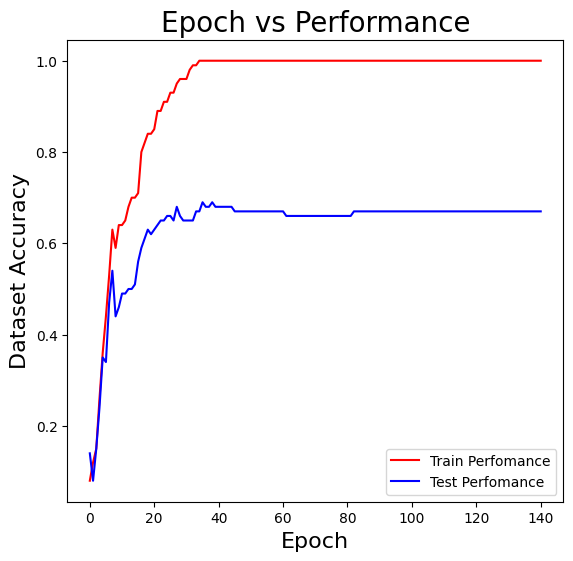

In [ ]:
# model 3 but trained for 140 epoch to match training length of the unnormalized model
more_epoch_model = MLPBackpropagation([256,256], relu, g, loss)
more_epoch_model.fit(trainX, trainY, 140, 0.005,testX, testY)

# evalulate performance
m_epoch_train = more_epoch_model.train_acc
m_epoch_test = more_epoch_model.test_acc

print("Training set performance:", m_epoch_train)
print("Test set performance:", m_epoch_test,'\n\n')

# plot the performance vs epoch
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(unnorm_epoch, m_epoch_train, label = "Train Perfomance", color = 'r')
plt.plot(unnorm_epoch, m_epoch_test, label = "Test Perfomance", color = 'b')

plt.title("Epoch vs Performance", fontsize = 20)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Dataset Accuracy", fontsize = 16)
plt.legend()

plt.show()

* # Compare the performance between the unnormalized and normalized models:

<Figure size 1200x480 with 0 Axes>

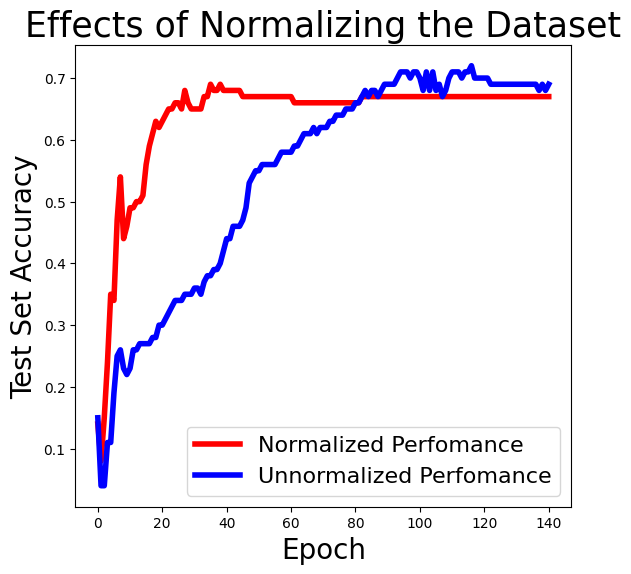

In [ ]:
# compare the performance between the unnormalized and normalized models
plt.figure().set_figwidth(12)
plt.figure().set_figheight(6)

plt.plot(unnorm_epoch, m_epoch_test, label = "Normalized Perfomance", color = 'r', linewidth = 4)
plt.plot(unnorm_epoch, unnorm_test_acc, label = "Unnormalized Perfomance", color = 'b', linewidth = 4)

plt.title("Effects of Normalizing the Dataset", fontsize = 25)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Test Set Accuracy", fontsize = 20)
plt.legend(fontsize = 16)

plt.show()